
----- 2D Thermal Expansion Simulation -----
Sheet dimensions: 10.0 × 5.0 mm
Temperature change: -650 K
Material 1 (top strip) - Alpha: 5.000000e-07 1/K
Material 2 (bottom) - Alpha: 3.000000e-06 1/K


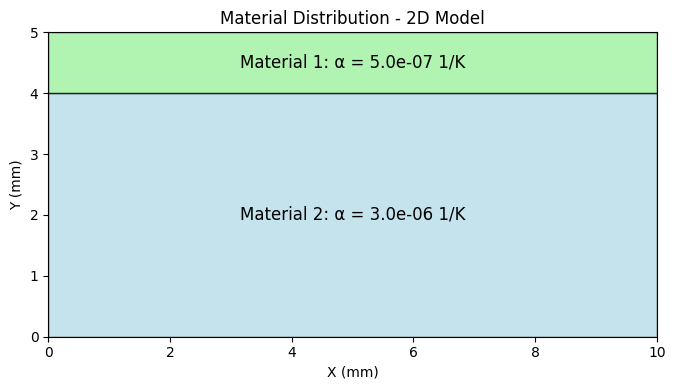


----- FEM Solution for Thermal Expansion (Edge Fixed) -----
Maximum displacement magnitude: 0.025762 mm

----- FEM Solution for Thermal Expansion (Points Fixed) -----
Maximum displacement magnitude: 0.015792 mm

Displacement fields exported to XDMF files for visualization in ParaView.


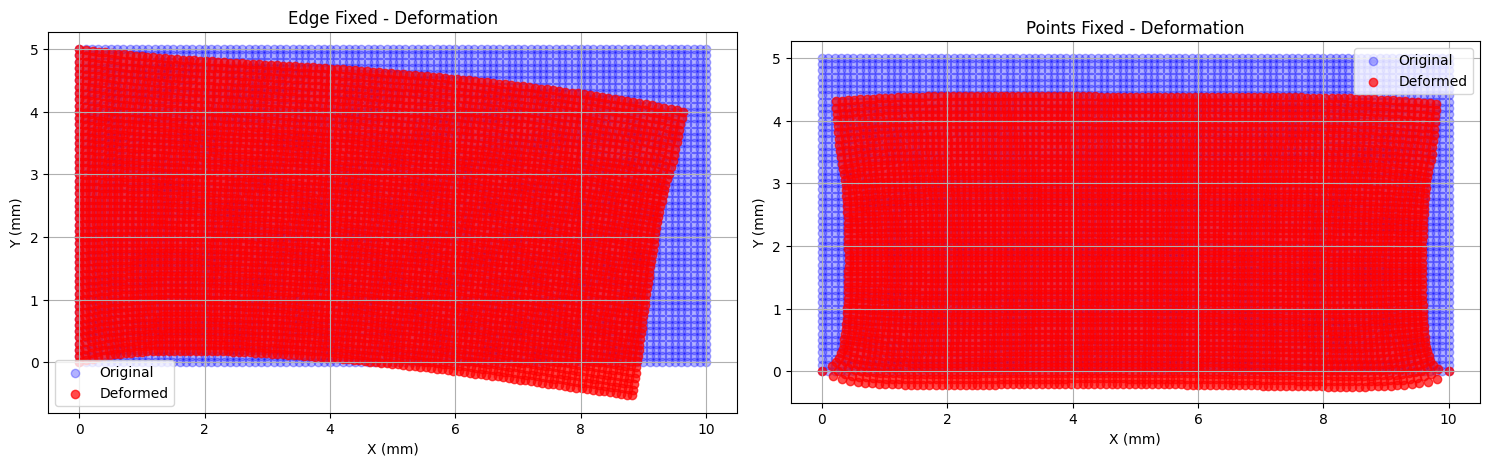

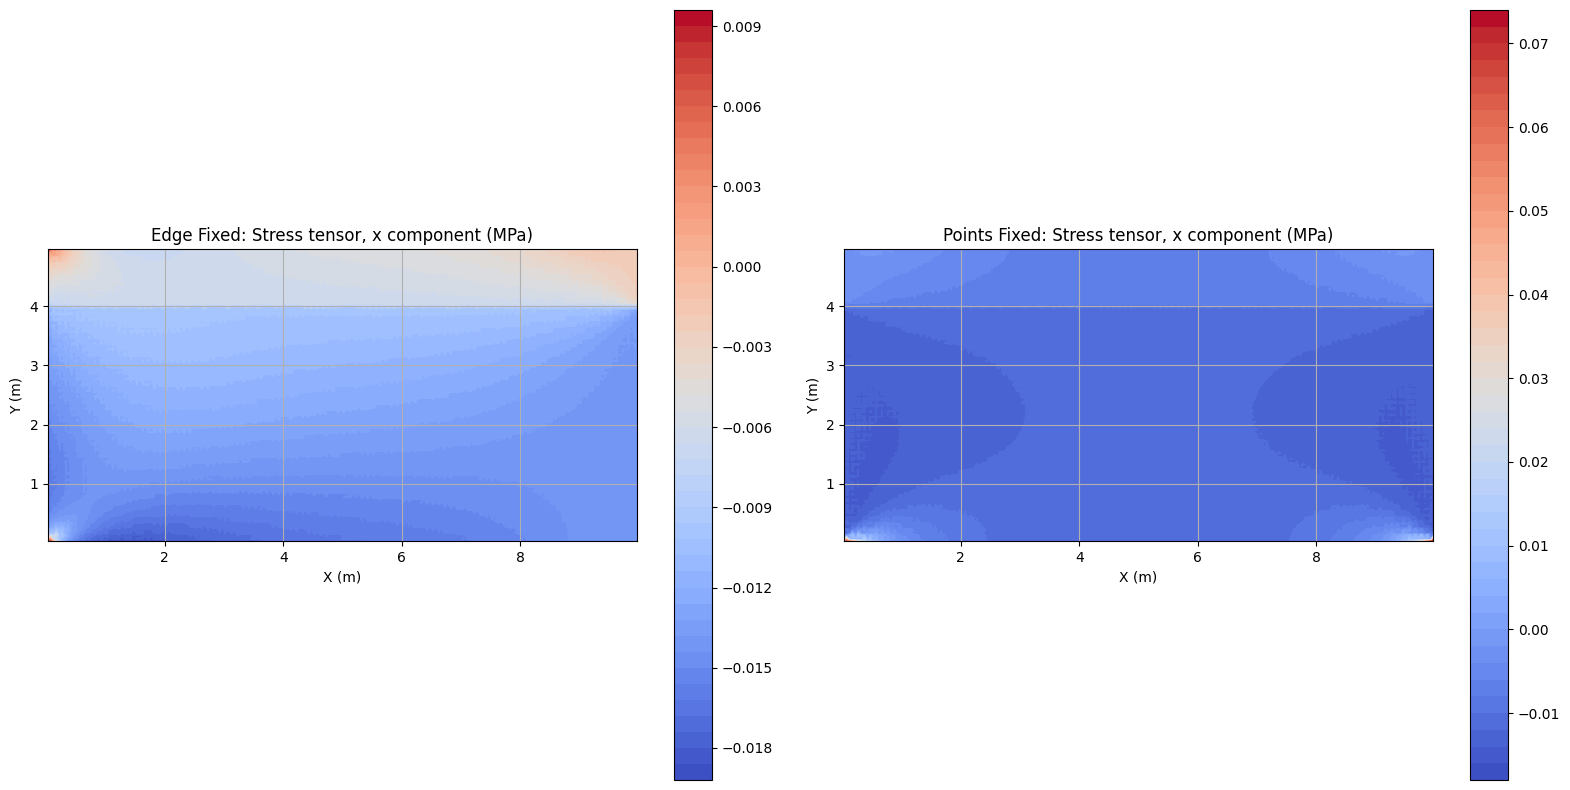

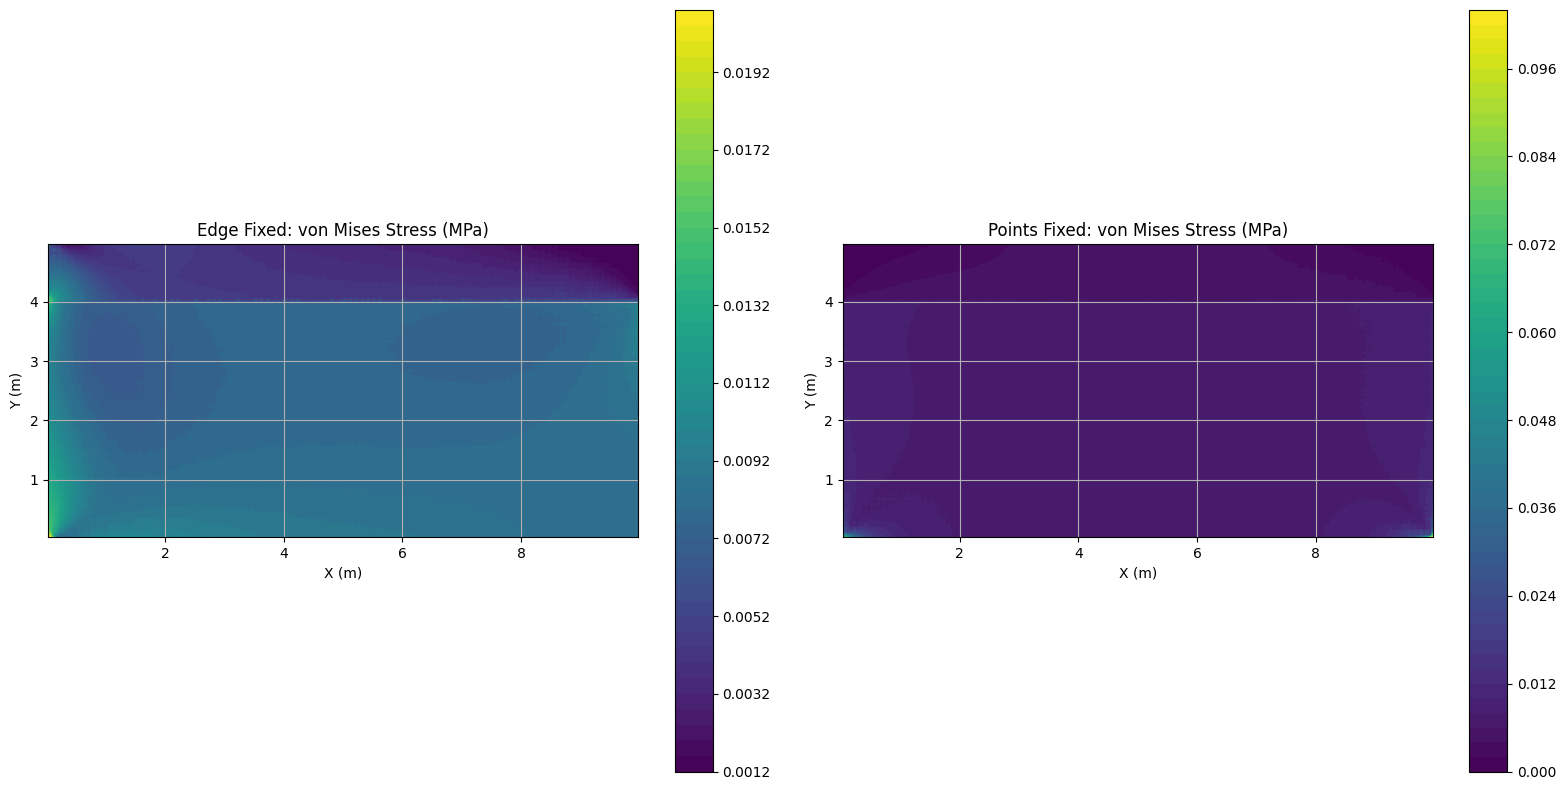

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import dolfinx
from dolfinx import mesh, fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile, VTXWriter
import ufl
from mpi4py import MPI
from petsc4py import PETSc

# Create communicator
comm = MPI.COMM_WORLD

# ------ Material properties ------
# Two different materials with different thermal expansion coefficients
E = 5  # Young's modulus (MPa) - same for both materials
nu = 0.3   # Poisson's ratio - same for both materials
alpha_1 = 5e-7  # Thermal expansion coefficient for material 1 (1/K)
alpha_2 = 3e-6  # Thermal expansion coefficient for material 2 (1/K) - higher expansion rate

# ------ Geometry parameters ------
Lx, Ly = 10.0, 5.0  # Initial dimensions (mm)
nx, ny = 100, 50    # Mesh divisions

# ------ Thermal parameters ------
initial_temp = 800  # Initial temperature (K)
final_temp = 150    # Final temperature (K) - cooling

# Calculate temperature change
delta_T = final_temp - initial_temp  # Negative for cooling

# ------ Define material regions ------
def material_1(x):
    """Domain for material 1 (top part of the sheet)"""
    return x[1] >= 4*Ly/5

def material_2(x):
    """Domain for material 2 (bottom part of the sheet)"""
    return x[1] < 4*Ly/5

# ------ FEM solution for constrained thermal expansion case 1: Edge fixed ------
def fem_solution_edge_fixed():
    """Calculate the FEM solution for thermal expansion with edge fixed"""
    print("\n----- FEM Solution for Thermal Expansion (Edge Fixed) -----")

    # Create 2D mesh (rectangle)
    domain = mesh.create_rectangle(comm,
                                  [np.array([0.0, 0.0]), np.array([Lx, Ly])],
                                  [nx, ny],
                                  mesh.CellType.triangle)

    # Create vector function space directly (2D)
    V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))

    # Define strain and stress for 2D plane stress
    def eps(u):
        """Strain tensor (2D)"""
        return ufl.sym(ufl.grad(u))

    # Calculate Lamé parameters
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - nu))  # Modified for plane stress

    # Mechanical stress (without thermal component)
    def sigma_mech(epsilon):
        """Mechanical stress tensor (2D plane stress)"""
        return 2.0 * mu * epsilon + lmbda * ufl.tr(epsilon) * ufl.Identity(2)

    # Create material markers
    cell_indices = np.arange(domain.topology.index_map(domain.topology.dim).size_local, dtype=np.int32)
    material_values = np.ones_like(cell_indices, dtype=np.int32)

    # Get cell midpoints
    midpoints = mesh.compute_midpoints(domain, domain.topology.dim, cell_indices)

    # Assign material markers
    material_1_cells = []
    material_2_cells = []

    for i, midpoint in enumerate(midpoints):
        if midpoint[1] >= 4*Ly/5:  # top part is material 1
            material_values[i] = 1
            material_1_cells.append(i)
        else:  # bottom part is material 2
            material_values[i] = 2
            material_2_cells.append(i)

    material_markers = mesh.meshtags(domain, domain.topology.dim, cell_indices, material_values)

    # Create cell marker function
    dx = ufl.Measure('dx', domain=domain, subdomain_data=material_markers)

    # Define boundary conditions: fix the left and bottom edges
    def left_edge(x):
        return np.isclose(x[0], 0.0)

    def bottom_edge(x):
        return np.isclose(x[1], 0.0)

    # Locate boundary facets for left edge
    left_facets = mesh.locate_entities_boundary(domain, domain.topology.dim-1, left_edge)
    left_dofs = fem.locate_dofs_topological(V, domain.topology.dim-1, left_facets)
    bc_left = fem.dirichletbc(np.zeros(2), left_dofs, V)  # 2D - only x,y components

    # Locate boundary facets for bottom edge
    bottom_facets = mesh.locate_entities_boundary(domain, domain.topology.dim-1, bottom_edge)
    bottom_dofs = fem.locate_dofs_topological(V, domain.topology.dim-1, bottom_facets)
    bc_bottom = fem.dirichletbc(np.zeros(2), bottom_dofs, V)  # 2D - only x,y components

    # Apply both boundary conditions
    bcs = [bc_left]

    # Create temperature field (uniform temperature change)
    T_space = fem.functionspace(domain, ("Lagrange", 1))
    T = fem.Function(T_space)
    T.interpolate(lambda x: np.full(x.shape[1], delta_T))

    # Setup variational problem
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Bilinear form - mechanical part
    a = ufl.inner(sigma_mech(eps(u)), eps(v)) * ufl.dx

    # Linear form - thermal part with different alpha for each material
    thermal_strain_1 = alpha_1 * delta_T * ufl.Identity(2)  # 2D
    thermal_strain_2 = alpha_2 * delta_T * ufl.Identity(2)  # 2D

    # Apply thermal strain to the weak form
    L = (ufl.inner((2*lmbda + 2*mu) * thermal_strain_1, eps(v)) * dx(1) +
         ufl.inner((2*lmbda + 2*mu) * thermal_strain_2, eps(v)) * dx(2))

    # Create function for solution
    u_sol = fem.Function(V)
    u_sol.name = "displacement"

    # Setup solver parameters using PETSc
    problem = LinearProblem(a, L, bcs=bcs, u=u_sol)
    u_sol = problem.solve()

    # Calculate von Mises stress
    stress_tensor = sigma_mech(eps(u_sol))

    # Calculate x-component of stress tensor (sigma_xx)
    sigma_xx = stress_tensor[0, 0]

    # Interpolate stress components to function space
    V_stress = fem.functionspace(domain, ("DG", 0))

    # X-component stress (sigma_xx)
    stress_xx_expr = fem.Expression(sigma_xx, V_stress.element.interpolation_points())
    stress_xx_func = fem.Function(V_stress)
    stress_xx_func.interpolate(stress_xx_expr)
    stress_xx_func.name = "stress_xx"

    # Calculate von Mises stress
    von_Mises = ufl.sqrt(3./2 * ufl.inner(stress_tensor - 1./3 * ufl.tr(stress_tensor) * ufl.Identity(len(u_sol)),
                                         stress_tensor - 1./3 * ufl.tr(stress_tensor) * ufl.Identity(len(u_sol))))
    vm_expr = fem.Expression(von_Mises, V_stress.element.interpolation_points())
    vm_func = fem.Function(V_stress)
    vm_func.interpolate(vm_expr)
    vm_func.name = "von_mises"

    # Export stress fields
    with XDMFFile(domain.comm, "stress_edge_fixed.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)
        xdmf.write_function(stress_xx_func)
        xdmf.write_function(vm_func)

    # Calculate maximum displacement
    u_values = u_sol.x.array
    num_nodes = u_values.size // 2  # 2D - only x,y components
    u_array = np.zeros((num_nodes, 2))
    u_array[:, 0] = u_values[0::2]  # x-components
    u_array[:, 1] = u_values[1::2]  # y-components

    max_disp = np.max(np.linalg.norm(u_array, axis=1))

    print(f"Maximum displacement magnitude: {max_disp:.6f} mm")

    return u_sol, domain, stress_xx_func, vm_func

# ------ FEM solution for constrained thermal expansion case 2: Points fixed ------
def fem_solution_points_fixed():
    """Calculate the FEM solution for thermal expansion with points fixed"""
    print("\n----- FEM Solution for Thermal Expansion (Points Fixed) -----")

    # Create 2D mesh (rectangle)
    domain = mesh.create_rectangle(comm,
                                  [np.array([0.0, 0.0]), np.array([Lx, Ly])],
                                  [nx, ny],
                                  mesh.CellType.triangle)

    # Create vector function space directly (2D)
    V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))

    # Define strain and stress for 2D plane stress
    def eps(u):
        """Strain tensor (2D)"""
        return ufl.sym(ufl.grad(u))

    # Calculate Lamé parameters
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - nu))  # Modified for plane stress

    # Define mechanical stress (without thermal component)
    def sigma_mech(epsilon):
        """Mechanical stress tensor (2D plane stress)"""
        return 2.0 * mu * epsilon + lmbda * ufl.tr(epsilon) * ufl.Identity(2)

    # Create material markers
    cell_indices = np.arange(domain.topology.index_map(domain.topology.dim).size_local, dtype=np.int32)
    material_values = np.ones_like(cell_indices, dtype=np.int32)

    # Get cell midpoints
    midpoints = mesh.compute_midpoints(domain, domain.topology.dim, cell_indices)

    # Assign material markers
    material_1_cells = []
    material_2_cells = []

    for i, midpoint in enumerate(midpoints):
        if midpoint[1] >= 4*Ly/5:  # top part is material 1
            material_values[i] = 1
            material_1_cells.append(i)
        else:  # bottom part is material 2
            material_values[i] = 2
            material_2_cells.append(i)

    material_markers = mesh.meshtags(domain, domain.topology.dim, cell_indices, material_values)

    # Create cell marker function
    dx = ufl.Measure('dx', domain=domain, subdomain_data=material_markers)

    # Define boundary conditions for points fixed case
    # Fix points at two corners to prevent rigid body motion
    def corner_point_1(x):
        return np.isclose(x[0], 0.0) & np.isclose(x[1], 0.0)

    def corner_point_2(x):
        return np.isclose(x[0], Lx) & np.isclose(x[1], 0.0)

    # Locate boundary vertices at corners
    vertices_1 = mesh.locate_entities_boundary(domain, 0, corner_point_1)
    vertices_2 = mesh.locate_entities_boundary(domain, 0, corner_point_2)

    dofs_1 = fem.locate_dofs_topological(V, 0, vertices_1)
    dofs_2 = fem.locate_dofs_topological(V, 0, vertices_2)

    bc1 = fem.dirichletbc(np.zeros(2), dofs_1, V)  # 2D - only x,y components
    bc2 = fem.dirichletbc(np.array([0.0, 0.0]), dofs_2, V)  # 2D - only x,y components

    bcs = [bc1, bc2]

    # Create temperature field (uniform temperature change)
    T_space = fem.functionspace(domain, ("Lagrange", 1))
    T = fem.Function(T_space)
    T.interpolate(lambda x: np.full(x.shape[1], delta_T))

    # Setup variational problem
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Bilinear form - mechanical part
    a = ufl.inner(sigma_mech(eps(u)), eps(v)) * ufl.dx

    # Linear form - thermal part with different alpha for each material
    thermal_strain_1 = alpha_1 * delta_T * ufl.Identity(2)  # 2D
    thermal_strain_2 = alpha_2 * delta_T * ufl.Identity(2)  # 2D

    # Apply thermal strain to the weak form
    L = (ufl.inner((2*lmbda + 2*mu) * thermal_strain_1, eps(v)) * dx(1) +
         ufl.inner((2*lmbda + 2*mu) * thermal_strain_2, eps(v)) * dx(2))

    # Create function for solution
    u_sol = fem.Function(V)
    u_sol.name = "displacement"

    # Setup solver parameters using PETSc
    problem = LinearProblem(a, L, bcs=bcs, u=u_sol)
    u_sol = problem.solve()

    # Calculate stress tensor
    stress_tensor = sigma_mech(eps(u_sol))

    # Calculate x-component of stress tensor (sigma_xx)
    sigma_xx = stress_tensor[0, 0]

    # Interpolate stress components to function space
    V_stress = fem.functionspace(domain, ("DG", 0))

    # X-component stress (sigma_xx)
    stress_xx_expr = fem.Expression(sigma_xx, V_stress.element.interpolation_points())
    stress_xx_func = fem.Function(V_stress)
    stress_xx_func.interpolate(stress_xx_expr)
    stress_xx_func.name = "stress_xx"

    # Calculate von Mises stress
    von_Mises = ufl.sqrt(3./2 * ufl.inner(stress_tensor - 1./3 * ufl.tr(stress_tensor) * ufl.Identity(len(u_sol)),
                                         stress_tensor - 1./3 * ufl.tr(stress_tensor) * ufl.Identity(len(u_sol))))
    vm_expr = fem.Expression(von_Mises, V_stress.element.interpolation_points())
    vm_func = fem.Function(V_stress)
    vm_func.interpolate(vm_expr)
    vm_func.name = "von_mises"

    # Export stress fields
    with XDMFFile(domain.comm, "stress_points_fixed.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)
        xdmf.write_function(stress_xx_func)
        xdmf.write_function(vm_func)

    # Calculate maximum displacement
    u_values = u_sol.x.array
    num_nodes = u_values.size // 2  # 2D - only x,y components
    u_array = np.zeros((num_nodes, 2))
    u_array[:, 0] = u_values[0::2]  # x-components
    u_array[:, 1] = u_values[1::2]  # y-components

    max_disp = np.max(np.linalg.norm(u_array, axis=1))

    print(f"Maximum displacement magnitude: {max_disp:.6f} mm")

    return u_sol, domain, stress_xx_func, vm_func

# ------ Visualization function for stress tensor ------
def plot_stress_tensor(stress_xx_edge, domain_edge, stress_xx_points, domain_points):
    """Plot stress tensor (x-component) for both cases"""

    # Create a function to get coordinates and values
    def get_coords_and_values(domain, func):
        # Get coordinates of mesh points
        x = domain.geometry.x

        # Get stress values at cells
        values = func.x.array

        # Get cell midpoints
        midpoints = mesh.compute_midpoints(domain, domain.topology.dim,
                                          np.arange(domain.topology.index_map(domain.topology.dim).size_local))

        return midpoints, values

    # Get coordinates and values for both cases
    midpoints_edge, values_edge = get_coords_and_values(domain_edge, stress_xx_edge)
    midpoints_points, values_points = get_coords_and_values(domain_points, stress_xx_points)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot for edge fixed case
    # Create a triangulation for plotting
    tri_edge = plt.matplotlib.tri.Triangulation(midpoints_edge[:, 0], midpoints_edge[:, 1])

    # Plot the stress field
    contour_edge = ax1.tricontourf(tri_edge, values_edge, cmap='coolwarm', levels=50)
    ax1.set_title('Edge Fixed: Stress tensor, x component (MPa)')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.grid(True)
    ax1.set_aspect('equal')
    fig.colorbar(contour_edge, ax=ax1)



    # Plot for points fixed case
    # Create a triangulation for plotting
    tri_points = plt.matplotlib.tri.Triangulation(midpoints_points[:, 0], midpoints_points[:, 1])

    # Plot the stress field
    contour_points = ax2.tricontourf(tri_points, values_points, cmap='coolwarm', levels=50)
    ax2.set_title('Points Fixed: Stress tensor, x component (MPa)')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.grid(True)
    ax2.set_aspect('equal')
    fig.colorbar(contour_points, ax=ax2)

    plt.tight_layout()
    plt.show()

# ------ Visualization function for von Mises stress ------
def plot_von_mises_stress(vm_edge, domain_edge, vm_points, domain_points):
    """Plot von Mises stress for both cases"""

    # Create a function to get coordinates and values
    def get_coords_and_values(domain, func):
        # Get coordinates of mesh points
        x = domain.geometry.x

        # Get stress values at cells
        values = func.x.array

        # Get cell midpoints
        midpoints = mesh.compute_midpoints(domain, domain.topology.dim,
                                          np.arange(domain.topology.index_map(domain.topology.dim).size_local))

        return midpoints, values

    # Get coordinates and values for both cases
    midpoints_edge, values_edge = get_coords_and_values(domain_edge, vm_edge)
    midpoints_points, values_points = get_coords_and_values(domain_points, vm_points)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot for edge fixed case
    # Create a triangulation for plotting
    tri_edge = plt.matplotlib.tri.Triangulation(midpoints_edge[:, 0], midpoints_edge[:, 1])

    # Plot the stress field
    contour_edge = ax1.tricontourf(tri_edge, values_edge, cmap='viridis', levels=50)
    ax1.set_title('Edge Fixed: von Mises Stress (MPa)')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.grid(True)
    ax1.set_aspect('equal')
    fig.colorbar(contour_edge, ax=ax1)



    # Plot for points fixed case
    # Create a triangulation for plotting
    tri_points = plt.matplotlib.tri.Triangulation(midpoints_points[:, 0], midpoints_points[:, 1])

    # Plot the stress field
    contour_points = ax2.tricontourf(tri_points, values_points, cmap='viridis', levels=50)
    ax2.set_title('Points Fixed: von Mises Stress (MPa)')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.grid(True)
    ax2.set_aspect('equal')
    fig.colorbar(contour_points, ax=ax2)



    plt.tight_layout()
    plt.show()

# ------ Visualization function ------
def plot_displacement(u_edge, domain_edge, u_points, domain_points):
    """Create plots showing displacement magnitude for both cases"""

    # Export to XDMF for visualization in ParaView
    with XDMFFile(comm, "displacement_edge_fixed_2d.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain_edge)
        xdmf.write_function(u_edge)

    with XDMFFile(comm, "displacement_points_fixed_2d.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain_points)
        xdmf.write_function(u_points)

    print("\nDisplacement fields exported to XDMF files for visualization in ParaView.")

# ------ Compute deformation shapes ------
def compute_deformation(u_sol, domain, scale_factor=10.0):
    """Compute the deformed mesh coordinates for visualization"""
    x = domain.geometry.x

    # Get displacement values
    u_values = u_sol.x.array
    num_nodes = u_values.size // 2  # 2D - only x,y components
    u_array = np.zeros((num_nodes, 2))
    u_array[:, 0] = u_values[0::2]  # x-components
    u_array[:, 1] = u_values[1::2]  # y-components

    # Scale displacements for better visualization
    u_array_scaled = u_array * scale_factor

    # Compute deformed coordinates
    x_deformed = x[:, :2] + u_array_scaled

    return x[:, :2], x_deformed

# ------ Visualization function for deformations ------
def plot_deformations(u_edge, domain_edge, u_points, domain_points):
    """Create plots showing initial and deformed shapes"""

    # Get original and deformed coordinates
    x_edge, x_deformed_edge = compute_deformation(u_edge, domain_edge, scale_factor=50.0)
    x_points, x_deformed_points = compute_deformation(u_points, domain_points, scale_factor=50.0)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plot for edge fixed case
    ax1.scatter(x_edge[:, 0], x_edge[:, 1], c='blue', alpha=0.3, label='Original')
    ax1.scatter(x_deformed_edge[:, 0], x_deformed_edge[:, 1], c='red', alpha=0.7, label='Deformed')
    ax1.set_title('Edge Fixed - Deformation')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.grid(True)
    ax1.legend()
    ax1.set_aspect('equal')

    # Plot for points fixed case
    ax2.scatter(x_points[:, 0], x_points[:, 1], c='blue', alpha=0.3, label='Original')
    ax2.scatter(x_deformed_points[:, 0], x_deformed_points[:, 1], c='red', alpha=0.7, label='Deformed')
    ax2.set_title('Points Fixed - Deformation')
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    ax2.grid(True)
    ax2.legend()
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

# ------ Visualization function for material regions ------
def visualize_material_regions():
    """Create a plot showing the material regions with thermal expansion coefficients"""
    fig, ax = plt.subplots(figsize=(8, 4))

    # Draw material regions
    material_2_rect = plt.Rectangle((0, 0), Lx, 4*Ly/5, fc='lightblue', ec='black', alpha=0.7)
    material_1_rect = plt.Rectangle((0, 4*Ly/5), Lx, Ly/5, fc='lightgreen', ec='black', alpha=0.7)

    ax.add_patch(material_2_rect)
    ax.add_patch(material_1_rect)

    # Add text labels for thermal expansion coefficients
    ax.text(Lx/2, 4.5*Ly/5, f"Material 1: α = {alpha_1:.1e} 1/K",
            ha='center', va='center', fontsize=12)
    ax.text(Lx/2, 2*Ly/5, f"Material 2: α = {alpha_2:.1e} 1/K",
            ha='center', va='center', fontsize=12)

    # Set axis properties
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_aspect('equal')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('Material Distribution - 2D Model')

    plt.tight_layout()
    plt.show()

def main():
    print("\n----- 2D Thermal Expansion Simulation -----")
    print(f"Sheet dimensions: {Lx} × {Ly} mm")
    print(f"Temperature change: {delta_T} K")
    print(f"Material 1 (top strip) - Alpha: {alpha_1:.6e} 1/K")
    print(f"Material 2 (bottom) - Alpha: {alpha_2:.6e} 1/K")

    # Visualize material regions
    visualize_material_regions()

    # Calculate FEM solution for edge fixed case
    u_edge, domain_edge, stress_xx_edge, vm_edge = fem_solution_edge_fixed()

    # Calculate FEM solution for points fixed case
    u_points, domain_points, stress_xx_points, vm_points = fem_solution_points_fixed()

    # Plot displacement fields
    plot_displacement(u_edge, domain_edge, u_points, domain_points)

    # Plot deformations
    plot_deformations(u_edge, domain_edge, u_points, domain_points)

    # Plot stress tensor (x-component)
    plot_stress_tensor(stress_xx_edge, domain_edge, stress_xx_points, domain_points)

    # Plot von Mises stress
    plot_von_mises_stress(vm_edge, domain_edge, vm_points, domain_points)

if __name__ == "__main__":
    main()